In [14]:
!pip install pandas numpy catboost openpyxl

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import pandas as pd

# 設定文件路徑
train_path = '/content/drive/MyDrive/Kaggle/data/train_使用經緯度_all (version 6).xlsx'
test_path = '/content/drive/MyDrive/Kaggle/data/test-reindex-test.xlsx'
valid_path = '/content/drive/MyDrive/Kaggle/data/valid.xlsx'

# 讀取資料
train = pd.read_excel(train_path)
test = pd.read_excel(test_path)
valid = pd.read_excel(valid_path)

In [41]:
import numpy as np
import pandas as pd
from datetime import datetime

# 定義基準日期
benchmark_date = pd.to_datetime('2024-01-01')

def preprocess_and_extract_features(df, benchmark_date):
    # 檢查日期是否已經轉換為西元格式
    def check_if_converted(df):
        sample_dates = df['交易年月日'].astype(str).head(3)
        for date in sample_dates:
            if len(date) == 10 and date[4] == '-' and date[7] == '-':
                return True
        return False

    # 將民國年轉換為西元年
    def convert_to_ad(year_str):
        """將民國年轉為西元年"""
        if len(year_str) == 7:  # 民國年格式YYYMMDD
            year = int(year_str[:3]) + 1911
            month = year_str[3:5]
            day = year_str[5:]
        elif len(year_str) == 6:  # 民國年格式YYMMDD
            year = int(year_str[:2]) + 1911
            month = year_str[2:4]
            day = year_str[4:]
        else:
            return None

        # 檢查月份或日期是否為 '00'
        if month == '00' or day == '00':
            return None
        else:
            return f"{year}-{month}-{day}"

    # 首先檢查是否已經是西元日期格式
    if check_if_converted(df):
        print("日期已經是西元格式，跳過轉換。")
        return df

    # 如果還沒有轉換，則進行轉換
    print("開始進行民國年到西元年的轉換...")
    df['交易年月日'] = df['交易年月日'].astype(str).apply(convert_to_ad)

    # 將轉換後的日期字串轉為 datetime 類型
    df['交易年月日'] = pd.to_datetime(df['交易年月日'], format='%Y-%m-%d', errors='coerce')

    # 去除無效日期的行
    df = df.dropna(subset=['交易年月日']).reset_index(drop=True)

    # 提取日期相關特徵
    df['交易年'] = df['交易年月日'].dt.year
    df['交易月'] = df['交易年月日'].dt.month
    df['交易日'] = df['交易年月日'].dt.day
    df['交易季度'] = df['交易年月日'].dt.quarter

    # 對月份進行正弦和餘弦變換
    df['交易月_sin'] = np.sin(2 * np.pi * df['交易月'] / 12)
    df['交易月_cos'] = np.cos(2 * np.pi * df['交易月'] / 12)

    # 計算距離基準日期的天數
    df['距離基準日期天數'] = (benchmark_date - df['交易年月日']).dt.days

    return df

# 對所有數據集應用此功能
train = preprocess_and_extract_features(train, benchmark_date)
valid = preprocess_and_extract_features(valid, benchmark_date)
test = preprocess_and_extract_features(test, benchmark_date)


開始進行民國年到西元年的轉換...
開始進行民國年到西元年的轉換...
開始進行民國年到西元年的轉換...


In [42]:
import re
import pandas as pd

def chinese_to_num(chinese_str):
    """將中文數字轉換為阿拉伯數字，並處理地下層"""
    chinese_num_map = {
        '零': 0, '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9,
        '十': 10, '十一': 11, '十二': 12, '十三': 13, '十四': 14, '十五': 15, '十六': 16, '十七': 17, '十八': 18, '十九': 19,
        '二十': 20, '二十一': 21, '二十二': 22, '二十三': 23, '二十四': 24, '二十五': 25, '二十六': 26, '二十七': 27, '二十八': 28, '二十九': 29,
        '三十': 30, '三十一': 31, '三十二': 32, '三十三': 33, '三十四': 34, '三十五': 35, '三十六': 36, '三十七': 37, '三十八': 38, '三十九': 39,
        '四十': 40, '四十一': 41, '四十二': 42, '四十三': 43, '四十四': 44, '四十五': 45, '四十六': 46, '四十七': 47, '四十八': 48, '四十九': 49,
        '五十': 50, '五十一': 51, '五十二': 52, '五十三': 53, '五十四': 54, '五十五': 55, '五十六': 56, '五十七': 57, '五十八': 58, '五十九': 59, '六十': 60
    }

    # 處理地下層數
    if isinstance(chinese_str, str) and chinese_str.startswith('地下'):
        return -chinese_num_map.get(chinese_str[2:], 0)

    # 將「層」去掉後轉換中文數字
    return chinese_num_map.get(chinese_str.replace('層', ''), None)

def create_floor_features(table):
    # 填充空值以避免處理空值時出錯
    table['移轉層次'] = table['移轉層次'].fillna('')

    # 節省內存處理，逐行處理，並防止內存溢出
    def process_row(row):
        floor_str = row['移轉層次']
        total_floors = row['總樓層數']

        # 處理 "全"、"整棟"、"全棟"、"全部" 等情況
        if any(keyword in floor_str for keyword in ['全', '整棟', '全棟', '全部']):
            floor_num = total_floors  # 如果是 "全" 表示樓層數等於總樓層數
        else:
            # 處理 "1-2層" 或 "1，2層" 等範圍情況，取範圍中的最大值
            range_match = re.findall(r'\d+', floor_str)
            if range_match:
                floor_num = max([int(x) for x in range_match])
            else:
                # 嘗試將中文數字轉換為數字
                floor_num = chinese_to_num(floor_str)

        # 頂樓判斷和樓層比例計算
        if total_floors > 0 and floor_num is not None:
            top_floor = (floor_num == total_floors)
            floor_ratio = floor_num / total_floors
        else:
            top_floor = False
            floor_ratio = 0

        return pd.Series([top_floor, floor_num, floor_ratio])

    # 使用 apply 逐行處理，但返回多個新欄位，避免多次操作表格
    table[['top_floor', '移轉層次_數值', 'floor_ratio']] = table.apply(process_row, axis=1)

    return table
train = create_floor_features(train)
valid = create_floor_features(valid)
test = create_floor_features(test)

# 查看結果
print(train[['移轉層次', '總樓層數', 'top_floor', 'floor_ratio']].head())
print(valid[['移轉層次', '總樓層數', 'top_floor', 'floor_ratio']].head())
print(test[['移轉層次', '總樓層數', 'top_floor', 'floor_ratio']].head())


  移轉層次  總樓層數  top_floor  floor_ratio
0   五層    10      False          0.5
1   四層     5      False          0.8
2   三層     5      False          0.6
3   二層     5      False          0.4
4   四層     5      False          0.8
  移轉層次  總樓層數  top_floor  floor_ratio
0   一層     4      False     0.250000
1   十層    15      False     0.666667
2   二層     7      False     0.285714
3   六層    15      False     0.400000
4    全     4       True     1.000000
   移轉層次  總樓層數  top_floor  floor_ratio
0     全     3       True     1.000000
1    八層    12      False     0.666667
2   十六層    25      False     0.640000
3  二十一層    29      False     0.724138
4   十二層    15      False     0.800000


In [43]:
# 檢查是否有重複的索引
print("Train 重複的索引數量:", train.index.duplicated().sum())
print("Valid 重複的索引數量:", valid.index.duplicated().sum())
print("Test 重複的索引數量:", test.index.duplicated().sum())


Train 重複的索引數量: 0
Valid 重複的索引數量: 0
Test 重複的索引數量: 0


In [44]:
def location_k_cluster(train, valid, test, cluster=500):
    from sklearn.cluster import KMeans
    import pandas as pd

    # 確保每次執行時資料的索引唯一
    train.reset_index(drop=True, inplace=True)
    valid.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)

    # 使用 train 中的經度和緯度來訓練 KMeans 模型
    kmeans = KMeans(n_clusters=cluster, random_state=42)
    kmeans.fit(train[['latitude', 'longitude']].to_numpy())  # 只使用緯度和經度進行聚類

    # 為 train 資料集添加 KMeans 特徵
    train_data = train[['latitude', 'longitude']].to_numpy()
    train_kmeans_features = pd.DataFrame(kmeans.transform(train_data),
                                         columns=[f"k{i}" for i in range(1, cluster+1)])
    train = pd.concat([train, train_kmeans_features], axis=1)

    # 為 valid 資料集添加 KMeans 特徵
    valid_data = valid[['latitude', 'longitude']].to_numpy()
    valid_kmeans_features = pd.DataFrame(kmeans.transform(valid_data),
                                         columns=[f"k{i}" for i in range(1, cluster+1)])
    valid = pd.concat([valid, valid_kmeans_features], axis=1)

    # 為 test 資料集添加 KMeans 特徵
    test_data = test[['latitude', 'longitude']].to_numpy()
    test_kmeans_features = pd.DataFrame(kmeans.transform(test_data),
                                        columns=[f"k{i}" for i in range(1, cluster+1)])
    test = pd.concat([test, test_kmeans_features], axis=1)

    # 分配聚類標籤（cluster）
    train['cluster'] = kmeans.predict(train[['latitude', 'longitude']].to_numpy())
    valid['cluster'] = kmeans.predict(valid[['latitude', 'longitude']].to_numpy())
    test['cluster'] = kmeans.predict(test[['latitude', 'longitude']].to_numpy())

    # 計算聚類內部的銷售數量
    for df in [train, valid, test]:
        cluster_sales_count = df['cluster'].value_counts().to_dict()
        df['cluster_based_internal_sales'] = df['cluster'].map(cluster_sales_count)

    # 計算其他統計值，針對每個數據集分別處理
    for df, ref_df in [(train, train), (valid, train), (test, train)]:
        # 聚類內相同用途比例
        purpose_ratio_map = ref_df.groupby('cluster')['主要用途'].value_counts(normalize=True).to_dict()
        df['cluster_based_purpose_ratio'] = df.apply(
            lambda x: purpose_ratio_map.get((x['cluster'], x['主要用途']), 0), axis=1
        )

        # 聚類內相同建物類型比例
        build_type_ratio_map = ref_df.groupby('cluster')['建物型態'].value_counts(normalize=True).to_dict()
        df['cluster_based_build_type_ratio'] = df.apply(
            lambda x: build_type_ratio_map.get((x['cluster'], x['建物型態']), 0), axis=1
        )

        # 聚類內部平均價格
        avg_price_map = ref_df.groupby('cluster')['單價元平方公尺'].mean().to_dict()
        df['cluster_internal_avgprice'] = df['cluster'].map(avg_price_map)

    return train, valid, test

# 執行函數來生成聚類特徵
train, valid, test = location_k_cluster(train, valid, test, cluster=500)

# 檢查是否有重複的列名稱
def check_duplicate_columns(df):
    duplicate_columns = df.columns[df.columns.duplicated()].tolist()
    if duplicate_columns:
        print("重複的列名稱:", duplicate_columns)
    else:
        print("沒有重複的列名稱。")

# 檢查是否有重複的列名稱
check_duplicate_columns(train)
check_duplicate_columns(valid)
check_duplicate_columns(test)

print(train.columns)


沒有重複的列名稱。
沒有重複的列名稱。
沒有重複的列名稱。
Index(['總價元', '鄉鎮市區', '交易標的', '縣市', '縣市鄉鎮市區', '土地位置建物門牌', '路名', '縣市鄉鎮市區路名',
       'latitude', 'longitude',
       ...
       'k496', 'k497', 'k498', 'k499', 'k500', 'cluster',
       'cluster_based_internal_sales', 'cluster_based_purpose_ratio',
       'cluster_based_build_type_ratio', 'cluster_internal_avgprice'],
      dtype='object', length=547)


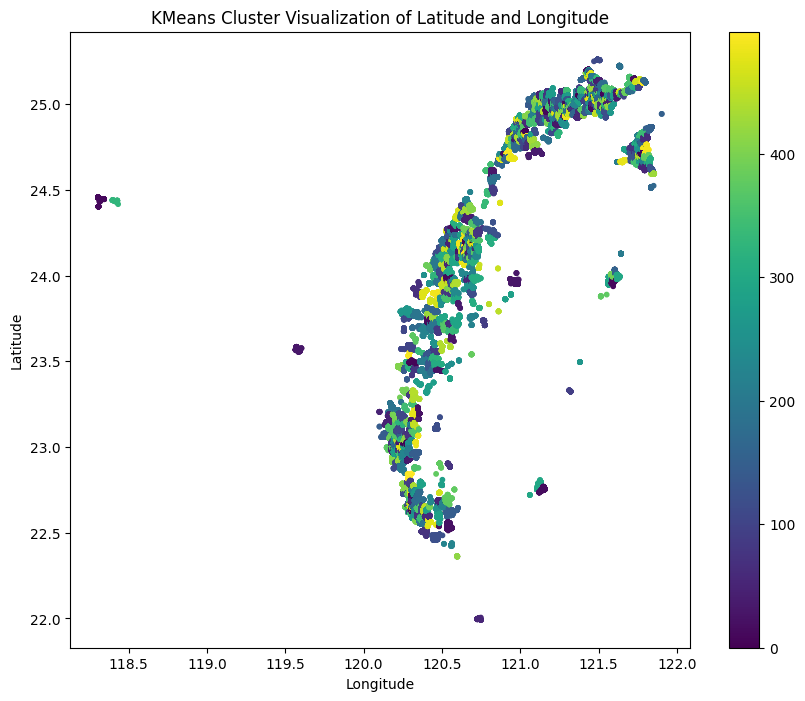

In [45]:
import matplotlib.pyplot as plt

# 可視化 KMeans 聚類結果
def visualize_k_cluster(train):
    # 設定畫布大小
    plt.figure(figsize=(10, 8))

    # 根據 cluster 分配顏色，並繪製經緯度的散點圖
    scatter = plt.scatter(train['longitude'], train['latitude'], c=train['cluster'], cmap='viridis', s=10)

    # 增加顏色條以便查看不同的 cluster
    plt.colorbar(scatter)

    # 添加標題和標籤
    plt.title('KMeans Cluster Visualization of Latitude and Longitude')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # 顯示圖像
    plt.show()

# 可視化 train 的 KMeans 聚類結果
visualize_k_cluster(train)


In [ ]:
"""def drop_outlier(df):"""
    """
    移除資料集中異常的數據
    - 土地移轉總面積平方公尺 < 7
    - 建物移轉總面積平方公尺 < 6
    - 車位移轉總面積平方公尺 < 6
    """
"""    df_cleaned = df[
        (df['土地移轉總面積平方公尺'] >= 7) &
        (df['建物移轉總面積平方公尺'] >= 6) &
        (df['車位移轉總面積平方公尺'] >= 6)
    ]
    return df_cleaned.reset_index(drop=True)

# 使用此函數來清理 train, valid, 和 test 數據
train_cleaned = drop_outlier(train)
valid_cleaned = drop_outlier(valid)
test_cleaned = drop_outlier(test)
"""

In [46]:
# 替換特徵名稱中的 '-' 為 '_'
train.columns = train.columns.str.replace('-', '_')
valid.columns = valid.columns.str.replace('-', '_')
test.columns = test.columns.str.replace('-', '_')

# 先計算 log_ratio 特徵
train['log_ratio'] = train['建物移轉總面積平方公尺'] - train['土地移轉總面積平方公尺']
valid['log_ratio'] = valid['建物移轉總面積平方公尺'] - valid['土地移轉總面積平方公尺']
test['log_ratio'] = test['建物移轉總面積平方公尺'] - test['土地移轉總面積平方公尺']

# 先將布林值轉換為 0 和 1
train['top_floor'] = train['top_floor'].astype(int)
valid['top_floor'] = valid['top_floor'].astype(int)
test['top_floor'] = test['top_floor'].astype(int)

# KMeans 特徵 'k1' 到 'k500' 需要加入數字特徵中
kmeans_features = [f'k{i}' for i in range(1, 501)]  # KMeans 生成的特徵列表

# 數字特徵包括之前的數字特徵、新創建的日期特徵、KMeans 生成的特徵
numeric_columns = ['latitude', 'longitude', '土地移轉總面積平方公尺',
                   '土地數量', '建物數量', '車位數量', '總樓層數', '建物移轉總面積平方公尺',
                   '建物現況格局_房', '建物現況格局_廳', '建物現況格局_衛',
                   '單價元平方公尺', '車位移轉總面積平方公尺', '車位總價元',
                   '交易年', '交易月', '交易日', '交易季度', '交易月_sin', '交易月_cos',
                   '距離基準日期天數', 'top_floor', 'floor_ratio',
                   'cluster_based_internal_sales', 'cluster_based_purpose_ratio',
                   'cluster_based_build_type_ratio', 'cluster_internal_avgprice',
                   'log_ratio'] + kmeans_features  # 添加 KMeans 生成的特徵和 log_ratio

# 類別特徵
categorical_columns = ['縣市鄉鎮市區路名', '鄉鎮市區', '交易標的', '縣市', '縣市鄉鎮市區', '都市土地使用分區',
                       '非都市土地使用分區', '非都市土地使用編定', '移轉層次',
                       '建物型態', '主要用途', '主要建材', '建物現況格局_隔間', '車位類別', 'cluster']  # 添加 cluster

# 確保 X_train, X_valid, X_test 中包含所有數字和類別特徵
all_features = numeric_columns + categorical_columns

In [47]:
X_train = train[all_features]
y_train = train['總價元']

X_valid = valid[all_features]
y_valid = valid['總價元']

X_test = test[all_features]

# 檢查是否有重複的列名稱
def check_duplicate_columns(df):
    duplicate_columns = df.columns[df.columns.duplicated()].tolist()
    if duplicate_columns:
        print("重複的列名稱:", duplicate_columns)
    else:
        print("沒有重複的列名稱。")

check_duplicate_columns(train)
check_duplicate_columns(valid)
check_duplicate_columns(test)

沒有重複的列名稱。
沒有重複的列名稱。
沒有重複的列名稱。


In [48]:
import pandas as pd

# 假設 X_train, X_valid, X_test 是三個 DataFrame
dataframes = [X_train, X_valid, X_test]

# 1. 處理數字特徵的缺失值
# 使用 .loc 來避免 SettingWithCopyWarning
for df in dataframes:
    df.loc[:, numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())

# 2. 處理類別特徵的缺失值
# 使用 .loc 並將缺失值填補為 'NaN'
for df in dataframes:
    df.loc[:, categorical_columns] = df[categorical_columns].fillna('NaN')

# 檢查是否缺失值已經被填補
print(X_train.isnull().sum())
print(X_valid.isnull().sum())
print(X_test.isnull().sum())

latitude       0
longitude      0
土地移轉總面積平方公尺    0
土地數量           0
建物數量           0
              ..
主要用途           0
主要建材           0
建物現況格局_隔間      0
車位類別           0
cluster        0
Length: 543, dtype: int64
latitude       0
longitude      0
土地移轉總面積平方公尺    0
土地數量           0
建物數量           0
              ..
主要用途           0
主要建材           0
建物現況格局_隔間      0
車位類別           0
cluster        0
Length: 543, dtype: int64
latitude       0
longitude      0
土地移轉總面積平方公尺    0
土地數量           0
建物數量           0
              ..
主要用途           0
主要建材           0
建物現況格局_隔間      0
車位類別           0
cluster        0
Length: 543, dtype: int64


In [ ]:
"""import pandas as pd

# 確保完整顯示所有欄位
pd.set_option('display.max_columns', None)  # 顯示所有列
pd.set_option('display.width', 1000)  # 增加顯示寬度來顯示更多內容

# 顯示 X_train 的前 5 行數據
print(X_valid.head())"""


畫圖

In [ ]:
# 下載台北思源黑體
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager

fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
mpl.rc('font', family='Taipei Sans TC Beta')

--2024-10-23 02:21:51--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 74.125.26.138, 74.125.26.139, 74.125.26.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.26.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-10-23 02:21:51--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.11.132, 2607:f8b0:400c:c01::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.11.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2024-10-23 02:21:54 (

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設定中文字體
plt.rcParams['axes.unicode_minus'] = False    # 解決負號顯示問題

# 數字特徵
numeric_columns = ['latitude', 'longitude', '土地移轉總面積平方公尺',
                   '土地數量', '建物數量', '車位數量', '總樓層數', '建物移轉總面積平方公尺',
                   '建物現況格局_房', '建物現況格局_廳', '建物現況格局_衛',
                   '單價元平方公尺', '車位移轉總面積平方公尺', '車位總價元',
                   '交易年', '交易月', '交易日', '交易季度', '交易月_sin', '交易月_cos',
                   '距離基準日期天數', 'top_floor', 'floor_ratio',
                   'cluster_based_internal_sales', 'cluster_based_purpose_ratio',
                   'cluster_based_build_type_ratio', 'cluster_internal_avgprice',
                   'log_ratio']

# 創建數字特徵的對角線箱型圖和其他特徵的散點圖
def plot_numeric_relationships(df):
    sns.pairplot(df[numeric_columns])
    plt.show()

# 繪製數字特徵之間的散點圖
def plot_scatter(df, x, y):
    sns.scatterplot(data=df, x=x, y=y)
    plt.title(f"{x} 與 {y} 的散點圖")
    plt.show()

# 繪製箱型圖，了解每個特徵的分佈
def plot_box(df, column):
    df[column].plot(kind='box')
    plt.title(f"{column} 的箱型圖")
    plt.show()

# 示例：查看 X_train 中所有數字特徵之間的關係
plot_numeric_relationships(test)

# 示例：查看單個數字特徵的箱型圖
plot_box(test, '建物移轉總面積平方公尺')

# 示例：查看經緯度之間的散點圖
plot_scatter(test, 'latitude', 'longitude')


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7bc97aa7a830> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7bc97aa79ab0> (for post_execute):


KeyboardInterrupt: 

XGBoost

In [49]:
from sklearn.preprocessing import LabelEncoder

# 需要進行 Label Encoding 的類別特徵
categorical_cols = categorical_columns  # 請確保 categorical_columns 內有所有類別特徵的名稱

# 合併 train 和 valid 數據，這樣可以在進行 Label Encoding 時保持一致
full_data = pd.concat([X_train, X_valid, X_test], axis=0)

# 對每個類別特徵進行 Label Encoding
label_enc = LabelEncoder()
for col in categorical_cols:
    full_data[col] = label_enc.fit_transform(full_data[col].astype(str))

# 分割回 train, valid, test
X_train = full_data.iloc[:len(X_train), :].reset_index(drop=True)
X_valid = full_data.iloc[len(X_train):len(X_train) + len(X_valid), :].reset_index(drop=True)
X_test = full_data.iloc[len(X_train) + len(X_valid):, :].reset_index(drop=True)


In [50]:
print(X_train.dtypes)
print(X_valid.dtypes)
print(X_test.dtypes)


latitude       float64
longitude      float64
土地移轉總面積平方公尺    float64
土地數量             int64
建物數量             int64
                ...   
主要用途             int64
主要建材             int64
建物現況格局_隔間        int64
車位類別             int64
cluster          int64
Length: 543, dtype: object
latitude       float64
longitude      float64
土地移轉總面積平方公尺    float64
土地數量             int64
建物數量             int64
                ...   
主要用途             int64
主要建材             int64
建物現況格局_隔間        int64
車位類別             int64
cluster          int64
Length: 543, dtype: object
latitude       float64
longitude      float64
土地移轉總面積平方公尺    float64
土地數量             int64
建物數量             int64
                ...   
主要用途             int64
主要建材             int64
建物現況格局_隔間        int64
車位類別             int64
cluster          int64
Length: 543, dtype: object


In [51]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import numpy as np
import gc

# Combine all datasets for label encoding
full_data = pd.concat([X_train, X_valid, X_test], axis=0)

# Perform Label Encoding for categorical features
label_enc = LabelEncoder()
for col in categorical_columns:
    full_data[col] = label_enc.fit_transform(full_data[col].astype(str))

# Split data back after label encoding
X_train = full_data.iloc[:len(X_train), :].reset_index(drop=True)
X_valid = full_data.iloc[len(X_train):len(X_train) + len(X_valid), :].reset_index(drop=True)
X_test = full_data.iloc[len(X_train) + len(X_valid):, :].reset_index(drop=True)

# Initialize cross-validation folds
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(X_train.shape[0])
test_preds = np.zeros(X_test.shape[0])

# GPU-accelerated training
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
    print(f'Fold {fold_ + 1}')

    # Prepare data for training and validation
    trn_data = xgb.DMatrix(X_train.iloc[trn_idx], label=y_train.iloc[trn_idx])
    val_data = xgb.DMatrix(X_train.iloc[val_idx], label=y_train.iloc[val_idx])
    test_data = xgb.DMatrix(X_test)

    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',  # Using Mean Absolute Error
        'learning_rate': 0.01,
        'max_depth': 6,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42,
        'tree_method': 'hist',  # Updated to 'hist'
        'device': 'cuda',       # Use GPU with CUDA
        'n_jobs': -1
    }

    # Train the model with GPU acceleration and early stopping
    clf = xgb.train(
        params,
        trn_data,
        num_boost_round=10000,
        evals=[(val_data, 'valid')],
        early_stopping_rounds=200,
        verbose_eval=500
    )

    # Retrieve best iteration and make predictions
    best_iteration = clf.best_iteration
    oof_preds[val_idx] = clf.predict(xgb.DMatrix(X_train.iloc[val_idx]), iteration_range=(0, best_iteration))
    test_preds += clf.predict(xgb.DMatrix(X_test), iteration_range=(0, best_iteration)) / folds.n_splits

    # Clean up memory to prevent overflow
    del trn_data, val_data, clf
    gc.collect()

# Evaluate model performance using MAE
mae = mean_absolute_error(y_train, oof_preds)
print(f'Overall MAE: {mae}')

# Prepare the submission
submission = pd.DataFrame({
    '編號': np.arange(1, len(test_preds) + 1),
    '總價元': test_preds
})

# Save submission to CSV
submission.to_csv('/content/drive/MyDrive/Kaggle/output/submission_with_log_restored_GPU.csv', index=False, encoding='utf-8-sig')

print(f'Submission saved successfully.')


Fold 1
[0]	valid-mae:0.41875
[500]	valid-mae:0.02530
[1000]	valid-mae:0.01625
[1500]	valid-mae:0.01344
[2000]	valid-mae:0.01199
[2500]	valid-mae:0.01116
[3000]	valid-mae:0.01057
[3500]	valid-mae:0.01014
[4000]	valid-mae:0.00978
[4500]	valid-mae:0.00948
[5000]	valid-mae:0.00923
[5500]	valid-mae:0.00901
[6000]	valid-mae:0.00881
[6500]	valid-mae:0.00863
[7000]	valid-mae:0.00847
[7500]	valid-mae:0.00832
[8000]	valid-mae:0.00818
[8500]	valid-mae:0.00805
[9000]	valid-mae:0.00793
[9500]	valid-mae:0.00783
[9999]	valid-mae:0.00772
Fold 2
[0]	valid-mae:0.41964
[500]	valid-mae:0.02525
[1000]	valid-mae:0.01622
[1500]	valid-mae:0.01350
[2000]	valid-mae:0.01214
[2500]	valid-mae:0.01134
[3000]	valid-mae:0.01074
[3500]	valid-mae:0.01030
[4000]	valid-mae:0.00994
[4500]	valid-mae:0.00963
[5000]	valid-mae:0.00937
[5500]	valid-mae:0.00915
[6000]	valid-mae:0.00895
[6500]	valid-mae:0.00877
[7000]	valid-mae:0.00860
[7500]	valid-mae:0.00846
[8000]	valid-mae:0.00833
[8500]	valid-mae:0.00819
[9000]	valid-mae:0.

In [37]:
import numpy as np
import pandas as pd

# 還原對數處理的房價
def inverse_log_predictions(log_predictions):
    return np.exp(log_predictions)

# 使用之前的 test_preds 進行預測 (test_preds 是在 Cross-validation 中累積的預測結果)
# 還原房價預測結果（從 log 還原到原始的總價元）
predictions = inverse_log_predictions(test_preds)

# 創建編號欄位，從 1 編號到資料最後一筆
submission = pd.DataFrame({
    '編號': np.arange(1, len(predictions) + 1),  # 編號從 1 開始
    '總價元': predictions
})

# 確保路徑正確並保存結果
submission_path = '/content/drive/MyDrive/Kaggle/output/submission_all_XGBoost_2.csv'
submission.to_csv(submission_path, index=False, encoding='utf-8-sig')

print(f"預測結果已保存至: {submission_path}")


預測結果已保存至: /content/drive/MyDrive/Kaggle/output/submission_all_XGBoost_2.csv


In [ ]:
#自訂義 MAE
import numpy as np

class maeMetric(object):
    def get_final_error(self, error, weight):
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return False

    def evaluate(self, approxes, target, weight):
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]  # 模型的預測結果（對數值）

        error_sum = 0.0
        weight_sum = 0.0

        for i in range(len(approx)):
            w = 1.0 if weight is None else weight[i]
            weight_sum += w
            # 還原對數轉換後的預測值和真實值，並計算 MAE
            pred_value = np.exp(approx[i])  # 還原對數預測值
            true_value = np.exp(target[i])  # 還原對數目標值
            error_sum += w * abs(pred_value - true_value)  # 計算絕對誤差

        return error_sum, weight_sum


In [ ]:
from catboost import CatBoostRegressor

# 定義使用最佳參數的 CatBoost 模型
model = CatBoostRegressor(
    #iterations=int(5.425e+03),  # 最佳迭代次數
    iterations=10000,
    depth=int(8.552),           # 最佳深度
    #learning_rate=0.01832,      # 最佳學習率
    #subsample=0.9798,           # 最佳隨機抽樣比例
    #bootstrap_type='Poisson',   # 使用 Poisson 支持 subsample 的類型
    loss_function='RMSE',
    eval_metric=maeMetric(),  # 使用自訂義的 MAE 作為評估指標
    grow_policy='Depthwise',    # 每次選擇深度最小的節點進行分裂
    l2_leaf_reg=2,              # L2 正則化
    cat_features=[X_train.columns.get_loc(col) for col in categorical_columns],  # 類別特徵
    verbose=1000,
    random_seed=42,
    od_type='Iter',
    od_wait=500,
    task_type='GPU'  # 指定使用 GPU 進行訓練
)

"""# 進行特徵選擇
def feature_selection(model):
    train_dataset = Pool(X_train, y_train, cat_features=categorical_columns)
    val_dataset = Pool(X_valid, y_valid, cat_features=categorical_columns)

    # 特徵選擇過程
    model.select_features(
        train_dataset,
        eval_set=val_dataset,
        steps=5,                          # 每次選擇的步驟數
        num_features_to_select=422,        # 選擇 422 個最重要的特徵
        features_for_select=list(X_train.columns),  # 所有的特徵列表
        train_final_model=False,           # 不進行最終模型的訓練
        logging_level='Verbose'            # 顯示詳細的過程
    )

# 執行特徵選擇
feature_selection(model_for_selection)"""

# 訓練模型
model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    use_best_model=True,
    plot=True
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because PythonUserDefinedPerObject is/are not implemented for GPU


Step #1 out of 5
0:	learn: 0.4103692	test: 0.4074961	best: 0.4074961 (0)	total: 344ms	remaining: 57m 20s
1000:	learn: 0.0100193	test: 0.0105430	best: 0.0105430 (1000)	total: 40.2s	remaining: 6m 1s
2000:	learn: 0.0087097	test: 0.0094557	best: 0.0094557 (2000)	total: 1m 17s	remaining: 5m 9s
3000:	learn: 0.0079112	test: 0.0088280	best: 0.0088280 (3000)	total: 1m 55s	remaining: 4m 30s
4000:	learn: 0.0073269	test: 0.0083747	best: 0.0083747 (4000)	total: 2m 35s	remaining: 3m 52s
5000:	learn: 0.0069369	test: 0.0080960	best: 0.0080960 (5000)	total: 3m 13s	remaining: 3m 12s
6000:	learn: 0.0065896	test: 0.0078474	best: 0.0078474 (6000)	total: 3m 51s	remaining: 2m 34s
7000:	learn: 0.0063169	test: 0.0076523	best: 0.0076523 (7000)	total: 4m 30s	remaining: 1m 55s
8000:	learn: 0.0061038	test: 0.0075057	best: 0.0075057 (8000)	total: 5m 8s	remaining: 1m 17s
9000:	learn: 0.0059218	test: 0.0073831	best: 0.0073830 (8999)	total: 5m 47s	remaining: 38.5s
9999:	learn: 0.0057580	test: 0.0072755	best: 0.0072755

In [ ]:
import numpy as np
# 還原對數處理的房價
def inverse_log_predictions(log_predictions):
    return np.exp(log_predictions)

# 進行預測
log_predictions = model.predict(X_test)

# 還原房價預測結果（從log還原到原始的總價元）
predictions = inverse_log_predictions(log_predictions)

# 創建編號欄位，從 1 編號到資料最後一筆
submission = pd.DataFrame({
    '編號': np.arange(1, len(predictions) + 1),  # 編號從 1 開始
    '總價元': predictions
})

# 將結果保存為 CSV，避免中文編碼問題，使用 utf-8-sig
submission_path = '/content/drive/MyDrive/Kaggle/output/submission_with_log_restored_31_RMSEMAE_5.csv'
submission.to_csv(submission_path, index=False, encoding='utf-8-sig')

print(f"預測結果已保存至: {submission_path}")